In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

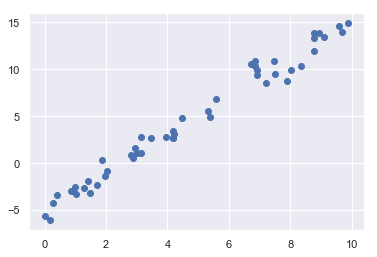

In [2]:
#Simple Linear Regression 
#Consider the following data, which is scattered about a line with a slope of 2 and an intercept
#of -5: 

rng = np.random.RandomState(1)
x=10*rng.rand(50)
y=2*x-5+rng.randn(50)
plt.scatter(x,y)

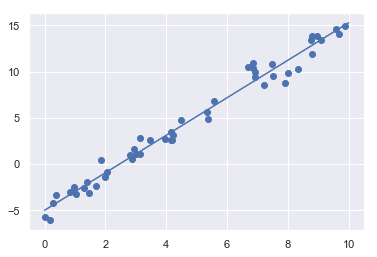

In [3]:
#We can use Scikit-Learn’s LinearRegression estimator to fit this data and construct the bestfit line :

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [4]:
#The slope and intercept of the data are contained in the model’s fit parameters, which in Scikit
#Learn are always marked by a trailing underscore. Here the relevant parameters are coef_ and
#intercept_:

print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)


Model slope:     2.027208810360695
Model intercept: -4.998577085553202


In [5]:
#The multidimensional nature such as regression makes them more difficult to visualize, but
#we can see one pf these fits in action by building some example data, using Numpy’s matrix
#multiplication operator : 

rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X,y)
print(model.intercept_)
print(model.coef_)

0.5000000000000144
[ 1.5 -2.   1. ]


In [6]:
#Polynomial Basis Functions 

from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [7]:
#Lets make a 7-th degree polynomial model this way :

from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

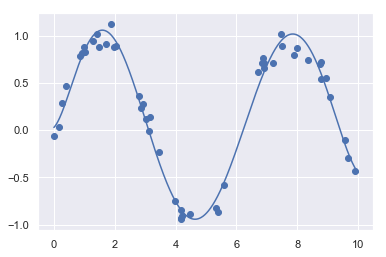

In [8]:
#With this transform in place, we can use the linear model to fit more complicated relationship
#between x and y. For example, her is a sine wave with noise :

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

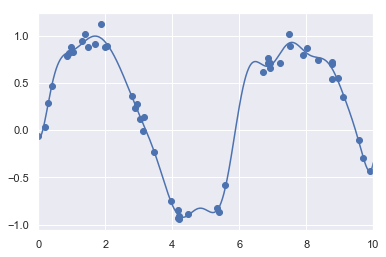

In [13]:
#Gaussian Basis Function 
#Scikit-learn transformers are implemented as Python classes; reading Scikit-Learn source is
#a good way to see how they can be created :

from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])   
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                     self.width_, axis=1)
        
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])
        
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

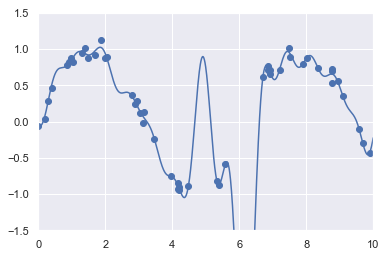

In [14]:
#Regularization
model = make_pipeline(GaussianFeatures(30),
                     LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

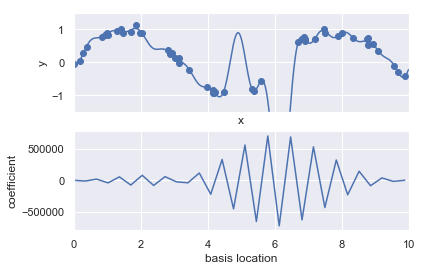

In [19]:
#With the data projected to the 30-dimensional basis, the model has far too much flexibility and
#goes to extreme values between locations where it is constrained by data. We can see the reason
#for this if we plot the coefficients of the Gaussian bases with respect to their locations :

def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
        
    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
        
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

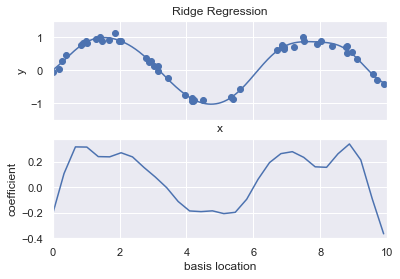

In [24]:
#Ridge Regression (L2 regularization) 
#. Ridge regression is a type of penalized model. If we build using Scikit-Learn, we use Ridge
#estimator

from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


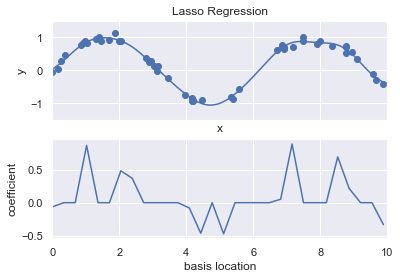

In [25]:
#Lasso Regression (L1 regularization)
#We can see this behavior in duplicating the ridge regression figure, but using L1-normalized
#coefficients :

from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

In [27]:
#Linear Regression Example : Predicting Bicycle Traffic
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [28]:
#Next we will compute the total daily bicycle traffic, and put this in this own dataframe :

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] #remove other columns


In [29]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [30]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

(8, 17)

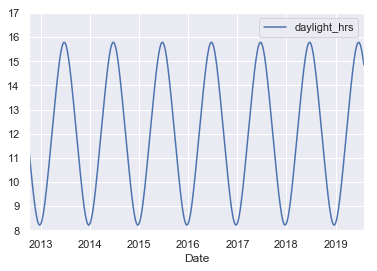

In [32]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)
    
    

In [33]:
#We can also add the average temperature and total precipitation to the data. In addition to
#the inches of precipitation; let’s add a flag that indicates whether a day is dry (has zero
#precipitation) 

#temperatures are in 1/10 deg C; convert to c
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

#precip is in 1/10; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [34]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [43]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000,3463.400275
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740,3361.947831
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479,3160.933823
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219,1908.094174
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959,1870.448616


In [44]:
# drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

columns_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                 'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[columns_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

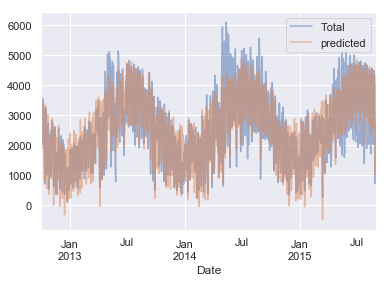

In [45]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [46]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

In [47]:
#These number are difficult to interpret without some measure of their uncertainty. We can
#compute these uncertainties quickly using bootstrap resampling of the data : 

from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
             for i in range(1000)], 0)

In [48]:
print(pd.DataFrame({'effect': params.round(0),
                   'error': err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0


In [49]:
#DECISION TREES LEARNING 
!pip install graphviz

In [51]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\LABC701-36\graphviz-2.38\release\bin'

In [53]:
!pip install mglearn

  Stored in directory: C:\Users\LABC701-36\AppData\Local\pip\Cache\wheels\74\cf\8d\04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn


In [54]:
import numpy as np
import sklearn.datasets
import mglearn
import matplotlib.pyplot as plt

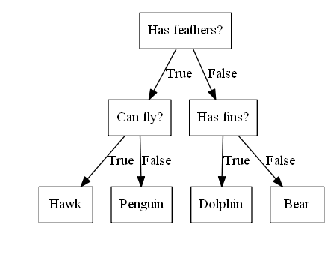

In [57]:
mglearn.plots.plot_animal_tree()

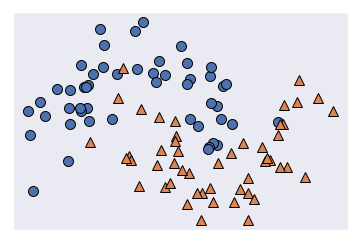

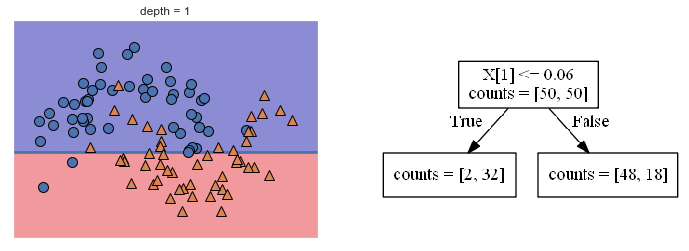

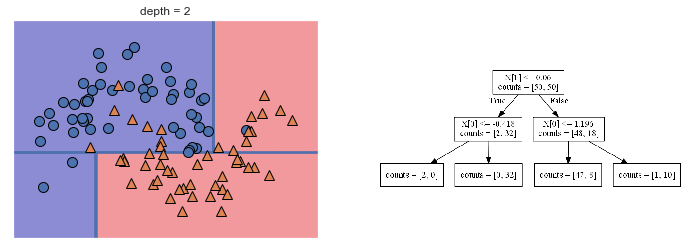

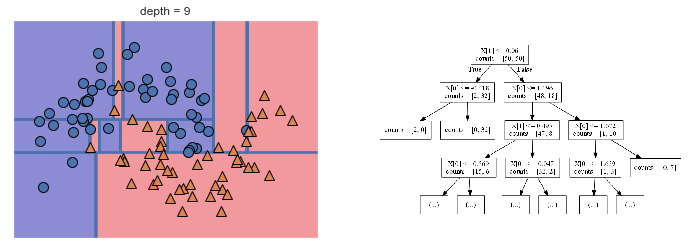

In [58]:
mglearn.plots.plot_tree_progressive()

In [59]:
#Decision trees in scikit-learn are implemented in the DecisionTreeRegressor and
#DecisionTreeClassifier classes. Scikit-learn only implements pre-pruning, not post-pruning

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x_train, x_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


In [61]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}". format(tree.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(x_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


In [62]:
#Analying Decision Trees

from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
               feature_names=cancer.feature_names, impurity=False, filled=True)

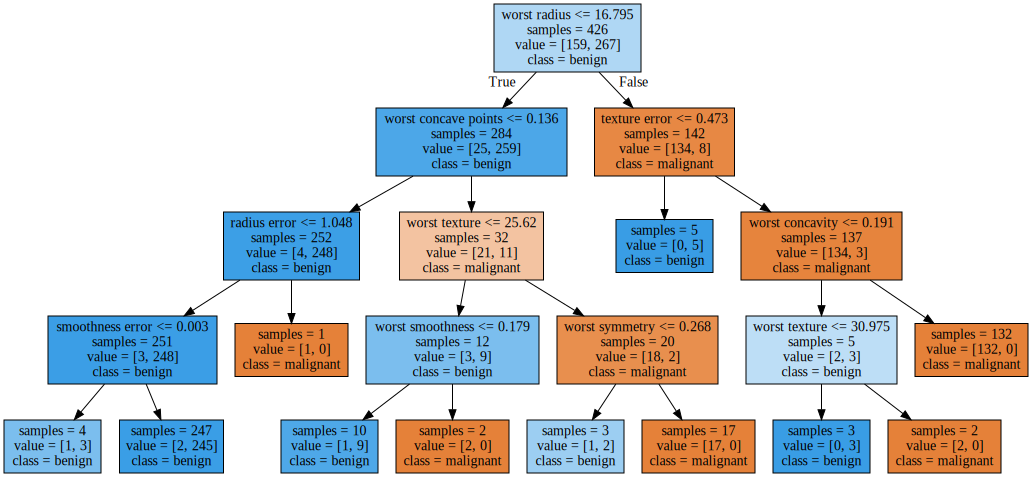

In [63]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [64]:
#Feature Importance in Trees

print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


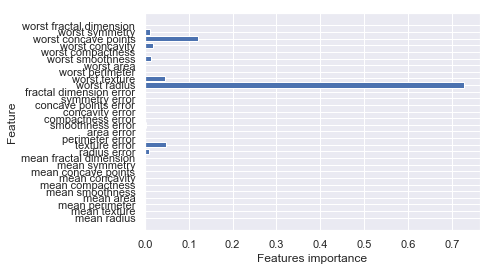

In [65]:
#Visualize the feature importances.
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Features importance")
    plt.ylabel("Feature")
    
plot_feature_importances_cancer(tree)


Feature importances: [0. 1.]


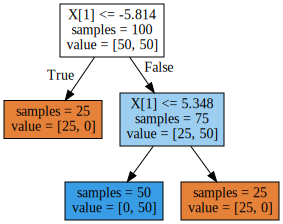

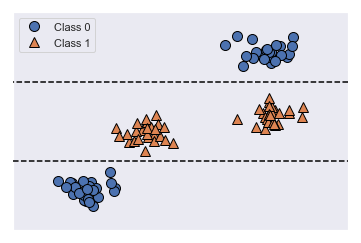

In [66]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

Text(0, 0.5, 'Price in $/Mbyte')

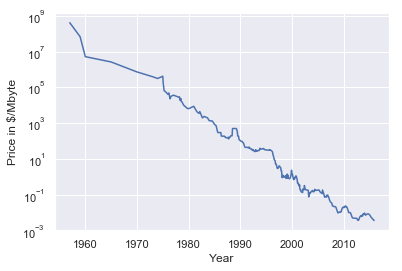

In [67]:
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

In [68]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

#use historicl data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

#predict prices based on date
x_train = data_train.date[:, np.newaxis]
#we use a log transform to get a smipler relationshi[ of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(x_train, y_train)
linear_reg = LinearRegression().fit(x_train, y_train)

#predict all data
x_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(x_all)
pred_lr = linear_reg.predict(x_all)

#undo log tranform

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

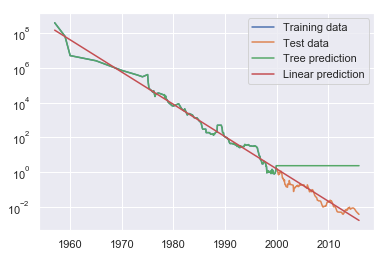

In [70]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()



In [72]:
#Random Forests

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, noise=0.25, random_state=3)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

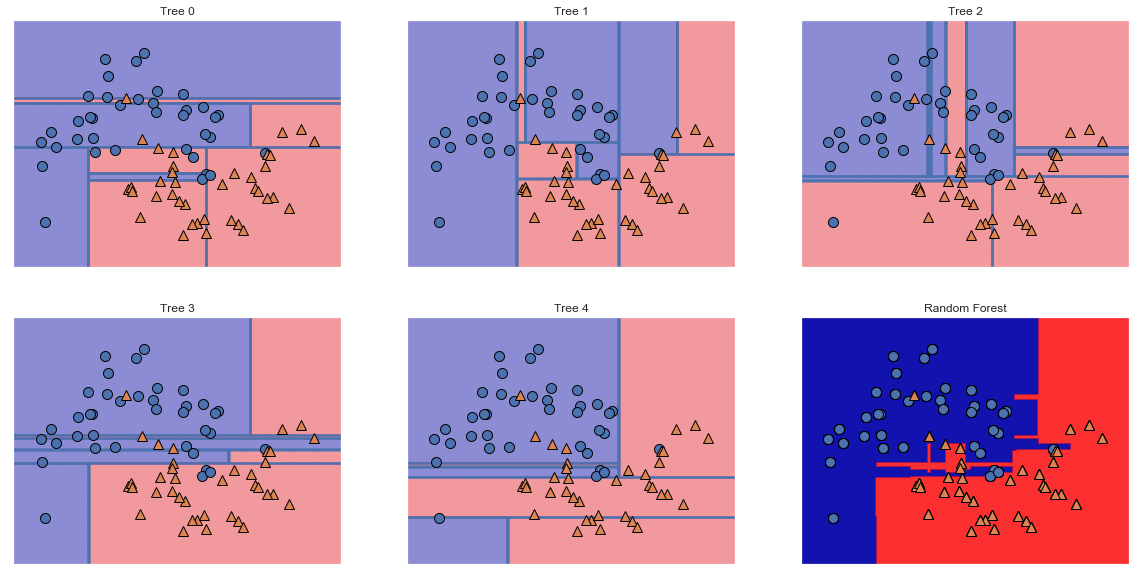

In [74]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(x_train, y_train, tree, ax=ax)
    
    mglearn.plots.plot_2d_separator(forest, x_train, fill=True, ax=axes[-1, -1], alpha=.4)
    axes[-1, -1].set_title("Random Forest")
    mglearn.discrete_scatter(x_train[:, 0], x_train[:, 1], y_train)


In [76]:
x_train, x_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(x_train, y_train)

print("Accuracy on training set {:.3f}".format(forest.score(x_train, y_train)))
print("Accuracy on test set {:.3f}".format(forest.score(x_test, y_test)))

Accuracy on training set 1.000
Accuracy on test set 0.972
